<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Fourth_Working_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install spektral -q

import numpy as np
import tensorflow as tf
import keras
import pickle

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor


from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GlobalMaxPool, GlobalAvgPool, GCNConv, ECCConv

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

PI = np.pi

# Lifehack
true = True
false = False

In [21]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [22]:
################################################################################
# LOAD DATA
################################################################################
# Find the reverse transformer
pcl = "/content/drive/MyDrive/Bachelor Project - IceCube ML/transformers.pkl"

with open(pcl,'rb') as tra:
    transformer = pickle.load(tra)

transformer = transformer["truth"]


class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      e,a,z = g["y"]
      g["y"] = [transformer['energy_log10'].transform([[e]])[0][0],transformer['azimuth'].transform([[a]])[0][0],transformer['zenith'].transform([[z]])[0][0]]
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])




#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)
Running on GPU


In [23]:
def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")

    energy    = tf.abs(target[:,0] - predictions[:,0])
    azi, zeni = tf.abs(target[:,1] - predictions[:,1]), tf.abs(target[:,2] - predictions[:,2])


    azi  = tf.minimum(azi, tf.abs(tf.abs(azi )-2*PI))     # 2 should be pi or 2pi
    zeni = tf.minimum(tf.abs(zeni), tf.abs(tf.abs(zeni)-2*PI))  # 2 should be pi or 2pi

    # azi, zeni = azi*10,zeni*10

    #Trying something crazy
    # more = 2
    # menergy, mazi, mzeni = tf.where(energy<tf.abs(predictions[:,0]-mean_energy),energy,energy*more), tf.where(azi<tf.abs(predictions[:,1]-mean_azimuth),azi,azi*more), tf.where(zeni<tf.abs(predictions[:,2]-mean_zenith),zeni,zeni*more)
    # energy,azi,zeni = menergy,mazi,mzeni


    loss = 0
    loss += tf.reduce_mean(tf.square(energy))
    loss += tf.reduce_mean(tf.square(azi))
    loss += tf.reduce_mean(tf.square(zeni))
    loss += 0.1
    return loss





In [24]:
################################################################################
# PARAMETERS
################################################################################
#@markdown ### Define the model and training parameters and sync with WandB
batch_size =  64#@param {type: "number"}

# one-variable network size changer
network_size = 512 #@param {type: "number"}

learning_rate = 1e-4  #@param {type: "number"}

training_epochs = 25 #@param {type: "slider", min: 10, max: 200}


loss_function = "custom_loss"  #@param ['custom_loss']

config = {
        "learning_rate": learning_rate,
        "epochs": training_epochs,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "architecture": "Broadening CNN - short but wide",
        "network_size": network_size,
        "dataset": "MuonGun"
      }

epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs



In [25]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)





class model_class(Model):
  def __init__(self,forward = False,):
    super().__init__()
    
    self.forward = forward

    steps = [i**2 for i in range(1,2)]

    # self.inp = ECCConv(network_size,activation="relu",n_out = network_size)
    # self.inp    = AGNNConv()
    self.inp = GCNConv(network_size)
    self.encode = [GCNConv(network_size*s, activation = "relu") for s in steps]
    self.decode = [Dense(network_size*s, activation = "relu") for s in steps[::-1]]
    self.pool   = [GlobalSumPool(), GlobalMaxPool(),GlobalAvgPool()]
    self.out    = Dense(n_out) 

  def call(self, inputs, training = False):
    x, a, i = inputs
    # a, e    = self.generate_edge_features(x, a) # NEXT STEP is implementing this for myself
    # x = self.inp([x,a,e])
    x = self.inp([x,a])

    for enc in self.encode:
      x = enc([x,a])
    
    xp0 = self.pool[0]([x,i])
    xp1 = self.pool[1]([x,i])
    xp2 = self.pool[2]([x,i])


    x_pools = [xp0,xp1,xp2]
    x = tf.concat(x_pools, axis = 1)

    for dec in self.decode:
      x = dec(x)

    x_out = self.out(x)

    return x_out

  #Shamelessly stolen from Johann
  def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return a, e

# Build model
model = model_class()

opt = Adam(lr=learning_rate)
loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
acc_fn = MeanAbsoluteError()


model.compile()
# model.build()

In [26]:
################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs



loss_fn = custom_loss

def fit(train_loader):
  run = wandb.init(project='IceCube GNN Bachelor',config = config)
  current_batch = 0
  model_loss = []
  model_acc = []
  vali_acc = []
  epoch = 0

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True)
  t.set_description(f'Currently on epoch {0} of {epochs} ')

  pb = []
  tar = []
  step = 0

  last_loss = 0
  for batch in train_loader:
      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)
      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results')

          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            vali_loss, va = validate(vali_inputs,vali_target)
            vali_acc.append(va)
          va = np.mean(vali_acc)

          m_loss = np.mean(model_loss)
          change = (m_loss-last_loss)/max(0.000001,last_loss)
          last_loss = m_loss

          s = "Train loss: {} - Train accuracy: {} - Loss change {:+.3f}% | Validation accuracy {} | Epoch: {}".format(m_loss, np.mean(model_acc), change*100,va, epoch)
          t.write(s)
          if epoch%5 == 0 and epoch != 0:
            print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])
          else:
            pb = model(inputs, training=False)
            tar = target


          wandb.log({
                    "train_loss": m_loss,
                    "train_accuracy": np.mean(model_acc),
                    "val_loss": va,
                    })




          model_loss = []
          model_acc = []
          vali_acc = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()
          epoch += 1

          t.set_description(f'Currently on epoch {epoch} of {epochs} ')


In [27]:
fit(train_loader)
print("\n\nTraining of the following model is now complete:")
model.summary()
save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"
pth = save_path + f"/{wandb.run.name}-{int(epochs)}epochs" 
# pth = save_path + "savetest"
model.save(pth)

Train loss: 37.994520669781956 - Train accuracy: 1.267197608947754 - Loss change +3799452066.978% | Validation accuracy 1.2999087572097778 | Epoch: 0
Train loss: 22.582819485617474 - Train accuracy: 0.7701308131217957 - Loss change -40.563% | Validation accuracy 0.29649630188941956 | Epoch: 1
Train loss: 7.673786507509674 - Train accuracy: 0.5717210173606873 - Loss change -66.019% | Validation accuracy 0.3301229178905487 | Epoch: 2
Train loss: 7.383893515967728 - Train accuracy: 0.5360537171363831 - Loss change -3.778% | Validation accuracy 0.2810201644897461 | Epoch: 3
Train loss: 1.9300854583944334 - Train accuracy: 0.33946847915649414 - Loss change -73.861% | Validation accuracy 0.30347248911857605 | Epoch: 4
Train loss: 7.875360509552567 - Train accuracy: 0.48184213042259216 - Loss change +308.032% | Validation accuracy 0.21141879260540009 | Epoch: 5
Two current guesses are
 [-2.1472895 -1.0286056 -1.2318062] [-1.6817951  -0.96262324 -1.0419354 ] for
 [-2.02667317 -1.27404852 -0.76

Testing model
Done! 
Model loss 0.2103064336839296 | Model accuracy 0.2103064336839296


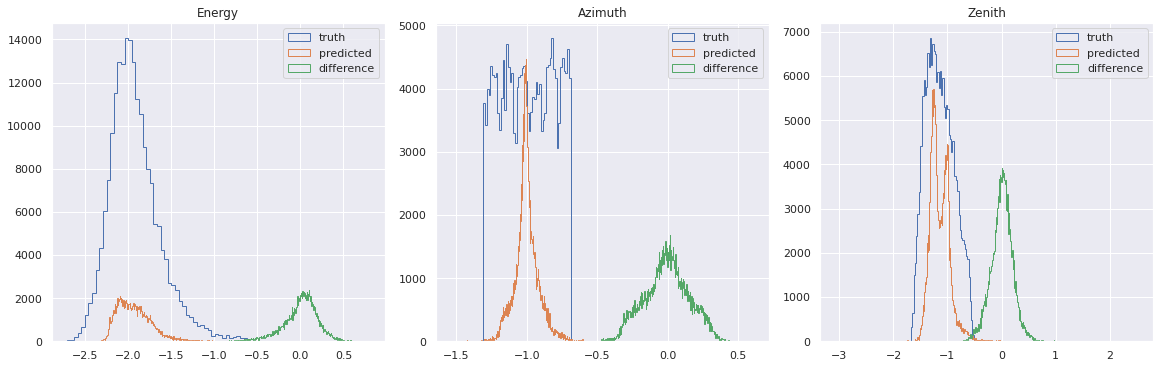

In [28]:
@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_predictions(inputs,target):
  return model(inputs,training = False)

def make1D(a):
  new = []
  for aa in a:
    for aaa in aa:
      new.append(aaa)
  return np.array(new)

def test_model():
  print("Testing model")
  model_loss, model_acc = [],[]

  test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=10,shuffle = True)

  predictions, truths = [],[]

  for batch in test_loader:
    inputs, target = batch
    inputs = scale_inputs(inputs)
    # print(inputs)
    pred = get_predictions(inputs,target)

    predictions.append(np.array(pred))
    truths.append(np.array(target))

    model_loss.append(loss_fn(target, pred))
    model_acc.append(acc_fn(target, pred))
  
  predictions = make1D(predictions)
  truths      = make1D(truths)

  print(f"Done! \nModel loss {np.mean(model_loss)} | Model accuracy {np.mean(model_loss)}")

  diffs = abs(truths-predictions)
  periodic = abs(abs(truths-predictions)-2)
  diffs = np.minimum(diffs,periodic)

  titles = ["Energy","Azimuth","Zenith"]

  fig, axs = plt.subplots(1,3,figsize=(16,5),constrained_layout=True)


  for i in range(3):
    axs[i].hist(truths[:,i],bins = 50,histtype = "step",label="truth")
    axs[i].hist(predictions[:,i],bins = 500,histtype = "step",label="predicted")
    axs[i].hist((predictions[:,i]-truths[:,i]),bins = 500,histtype = "step",label="difference")

    axs[i].legend()
    axs[i].set_title(titles[i])
  return predictions, truths

predictions, truths = test_model()